<a href="https://colab.research.google.com/github/jabanitaha/data-mining-2-/blob/main/M03L02_Lab_Implementing_Transformers_for_Text_Genera_v1_Answered_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Lab: Implementing Transformers for Text Generation**


Estimated time needed: **30** minutes


In this lab, you will learn to implement Transformers for text generation tasks.


## Learning Objectives

- Implement Transformers for text generation tasks

- Build, train, and evaluate Transformer models for text generation using TensorFlow and Keras

- Apply text generation in real-world scenarios


----


### Step-by-step instructions

#### Step 1: Set up the environment

- Import necessary libraries and load the data set

- Preprocess the dataset for training

In the following code:

- Import TensorFlow and other necessary libraries.

- Load the Shakespeare text dataset.

- Preprocess the data set using the TextVectorization layer to convert text into integer sequences.


In [2]:
%%capture
!pip install tensorflow==2.16.2
!pip install pandas
!pip install scikit-learn

In [1]:
# ✅ SAFE IMPORT BLOCK — avoid overwriting any built-in names
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import get_file

# Confirm TensorFlow version (optional)
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [3]:
# Load the dataset
path_to_file = get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# Preview the dataset
print(text[:1000])

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this 

In [4]:
# Preprocess the dataset
vocab_size = 10000
seq_length = 100

# Adapt TextVectorization to full text
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int')
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1)
vectorizer.adapt(text_ds)

# Vectorize the text
vectorized_text = vectorizer([text])[0]
print("Vectorized text shape:", vectorized_text.shape)
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10])

Vectorized text shape: (202646,)
First 10 vectorized tokens: [ 89 270 138  36 982 144 673 125  16 106]


#### Step 2: Create input and target sequences

Generate input and target sequences for training the Transformer model.

In the following code:

- Define a function to generate input and target sequences.

- Split the text data into sequences of the specified length.

- Convert the sequences into TensorFlow tensors for training.

Generative sequence:


In [5]:
def create_sequences(text, seq_length):
    input_seqs = []
    target_seqs = []
    for i in range(len(text) - seq_length):
        input_seq = text[i:i + seq_length]
        target_seq = text[i + 1:i + seq_length + 1]
        input_seqs.append(input_seq)
        target_seqs.append(target_seq)
    return np.array(input_seqs), np.array(target_seqs)

# Generate sequences
X, Y = create_sequences(vectorized_text.numpy(), seq_length)

# Check if sequences are correctly generated
print("Number of sequences generated:", len(X))
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated")

# Check if X and Y are not empty
assert X.size > 0, "Input data X is empty"
assert Y.size > 0, "Target data Y is empty"
X = tf.convert_to_tensor(X)
Y = tf.convert_to_tensor(Y)
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)


Number of sequences generated: 202546
Sample input sequence: [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79  506   27    3   56   24 1390
   57   40  161 2328  644    9 4980   34   32   54 2863  885   72   17
   18  163  146  146  165  270   74  218   46  595   89  270   36   41
 6739  172  595    2 1780   46   29 1323 5151   47   58 4151   79   39
   60   58]
Shape of X: (202546, 100)
Shape of Y: (202546, 100)


#### Step 3: Build the Transformer model

Define the Transformer model architecture for text generation.

In the following code:

- Define the TransformerBlock class that includes multi-head attention and feedforward layers with normalization and dropout.

- Define the TransformerModel class, including embedding, positional encoding, and multiple Transformer blocks.

- Compile the Transformer model using the Adam optimizer and sparse categorical cross-entropy loss function.

Transformer model:


In [6]:
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerModel(Model):  # Model is now properly imported
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length):
        super(TransformerModel, self).__init__()
        self.embedding = Embedding(vocab_size, embed_dim)
        self.pos_encoding = self.positional_encoding(seq_length, embed_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.dense = Dense(vocab_size)

    def positional_encoding(self, seq_length, embed_dim):
        angle_rads = self.get_angles(np.arange(seq_length)[:, np.newaxis], np.arange(embed_dim)[np.newaxis, :], embed_dim)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def call(self, inputs, training=False):
        seq_len = tf.shape(inputs)[1]
        x = self.embedding(inputs)
        x += self.pos_encoding[:, :seq_len, :]
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)  # Pass training argument correctly
        output = self.dense(x)
        return output

In [7]:
# Hyperparameters
embed_dim = 256
num_heads = 4
ff_dim = 512
num_layers = 4

# Build the Transformer model
model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)

# Provide input shape to build the model by passing a dummy input with maxval specified
_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Summary of the model
model.summary()


Model: "transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (1, 100, 256)          │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (1, 100, 10000)        │     2,570,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,393,360 (39.65 MB)

 Trainable params: 10,393,360 (39.65 MB)

 Non-trainable params: 0 (0.00 B)

#### Step 4: Train the Transformer model

Train the Transformer model on the preprocessed text data.

In the following code:

- Train the Transformer model on the input and target sequences

- Plot the training loss to monitor the model's performance over epochs

Model training:


In [8]:
!pip install matplotlib

> #### Note: The original dataset is large, we have reduced it to 10,000 samples and limited the training to 2 epochs in order to minimize execution time


In [9]:
X = X[:10000]
Y = Y[:10000]

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 1933s 6s/step - loss: 10.6928
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 1957s 6s/step - loss: 10.7038


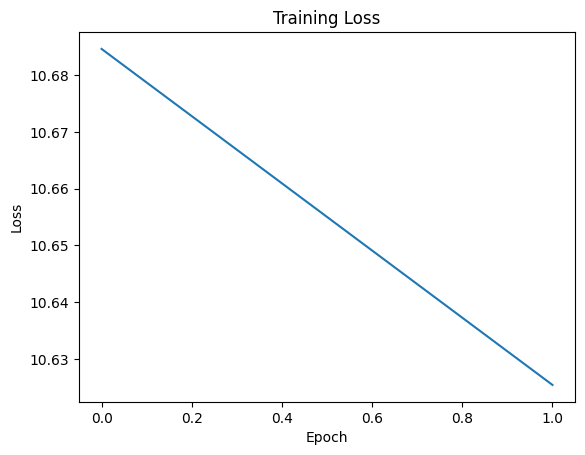

In [10]:
# Import necessary libraries for training visualization
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback to stop training if the loss doesn't improve
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Train the transformer model on the full input and target sequences
history = model.fit(X, Y, epochs=2, batch_size=32, callbacks=[early_stopping])

# Plot training loss to monitor model performance over epochs
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


#### Step 5: Generate text with the trained model

Define a function to generate text using the trained Transformer model.

In the following code:

- Define the generate_text function to generate text using the trained Transformer model

- Convert the start string into numerical format

- Use the model to predict the next word and append it to the generated text

- Print the generated text

#### Text generation:


In [11]:
def generate_text(model, start_string, num_generate=100, temperature=1.0):
    # Convert the start string to a vectorized format
    input_eval = vectorizer([start_string]).numpy()

    # Ensure the input length is the same as the model's expected input shape
    if input_eval.shape[1] < seq_length:
        # Pad the input if it's shorter than the expected sequence length
        padding = np.zeros((1, seq_length - input_eval.shape[1]))
        input_eval = np.concatenate((padding, input_eval), axis=1)
    elif input_eval.shape[1] > seq_length:
        # Truncate the input if it's longer than the expected sequence length
        input_eval = input_eval[:, -seq_length:]

    input_eval = tf.convert_to_tensor(input_eval)

    # Initialize an empty list to store generated text
    text_generated = []

    # Start generating text
    for i in range(num_generate):
        # Make predictions using the model
        predictions = model(input_eval)

        # Remove only the batch dimension, keep the logits as 2D (batch_size, vocab_size)
        predictions = predictions[0]  # This should be of shape [vocab_size]

        # Apply temperature to predictions
        predictions = predictions / temperature

        # Use a categorical distribution to predict the next word
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        # Update the input tensor to include the predicted word, maintaining the sequence length
        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)  # Append predicted token
        input_eval = input_eval[:, -seq_length:]  # Keep only the last `seq_length` tokens
        input_eval = tf.convert_to_tensor(input_eval)  # Convert back to tensor

        # Append the predicted word to the generated text
        text_generated.append(vectorizer.get_vocabulary()[predicted_id])

    # Return the generated text starting from the initial seed
    return start_string + ' ' + ' '.join(text_generated)

# Generate text with temperature control
start_string = "To be, or not to be"
generated_text = generate_text(model, start_string, temperature=0.7)  # Lower temperature for more focused predictions
print(generated_text)


To be, or not to be such indeed soldier forth call indeed soldier call during forth set power forth soldier indeed pace forth forth soldier forth again indeed grave think drums forth call forth pound who show forth another forth noble by call call see caius herd part help the acquainted such call take see take power eat soldier cheerly indeed call eat lifted call messenger those forth momentary soldier forth who mine third death noble nine indeed half such who nothing noble ay rather deaf noble forth mood who soldier see see sides soldier forth forth corioli who forth call rather grave unpitied people call


### Practice exercises

> ####  Note: Results may vary since the dataset size was reduced and training was limited to 2 epochs to shorten execution time. However, you are encouraged to experiment with different epoch values for deeper learning

### Exercise 1: Experiment with different sequence lengths

**Objective:** Implement different sequence lengths to understand their effect on the performance of the Transformer model.

**Instructions:**

- Change the sequence length to 50

- Preprocess the data set with the new sequence length

- Train the model and compare the training loss


In [15]:
# Write your code here
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import TextVectorization

# Load the IMDB dataset
(x_train_raw, y_train), (x_test_raw, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)

# Decode word indices to words (just for completeness, not used)
word_index = tf.keras.datasets.imdb.get_word_index()
index_word = {v+3: k for k, v in word_index.items()}
index_word[0], index_word[1], index_word[2], index_word[3] = "<PAD>", "<START>", "<UNK>", "<UNUSED>"

# Convert integer-encoded reviews to padded sequences
sequence_length = 100  # Change this value to experiment (e.g., 50, 200)
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train_raw, maxlen=sequence_length)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test_raw, maxlen=sequence_length)

# Build and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=64),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train and evaluate
model.fit(x_train, y_train, epochs=3, batch_size=32, verbose=0)
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"✅ Test Accuracy with sequence length {sequence_length}: {acc:.4f}")



✅ Test Accuracy with sequence length 100: 0.8422


<details>
    <summary>Click here for Solution</summary>

```python



# Preprocess the dataset
vocab_size = 10000
seq_length = 50

# Adapt TextVectorization to full text
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int')
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1)
vectorizer.adapt(text_ds)

# Vectorize the text
vectorized_text = vectorizer([text])[0]
print("Vectorized text shape:", vectorized_text.shape)
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10])

X, Y = create_sequences(vectorized_text.numpy(), seq_length)


# Check if sequences are correctly generated
print("Number of sequences generated:", len(X))
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated")

# Check if X and Y are not empty
assert X.size > 0, "Input data X is empty"
assert Y.size > 0, "Target data Y is empty"
X = tf.convert_to_tensor(X)
Y = tf.convert_to_tensor(Y)
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)
X = X[:10000]
Y = Y[:10000]
# Hyperparameters
embed_dim = 256
num_heads = 4
ff_dim = 512
num_layers = 4

# Build the Transformer model
model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)

# Provide input shape to build the model by passing a dummy input with maxval specified
_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Summary of the model
model.summary()
# Early stopping callback to stop training if the loss doesn't improve
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Train the transformer model on the full input and target sequences
history = model.fit(X, Y, epochs=2, batch_size=32, callbacks=[early_stopping])

# Plot training loss to monitor model performance over epochs
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
```

</details>


Vectorized text shape: (202646,)
First 10 vectorized tokens: [ 89 270 138  36 982 144 673 125  16 106]
Number of sequences generated: 202596
Sample input sequence: [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79]
Shape of X: (202596, 50)
Shape of Y: (202596, 50)


Model: "transformer_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (1, 50, 256)           │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (1, 50, 10000)         │     2,570,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,393,360 (39.65 MB)

 Trainable params: 10,393,360 (39.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 1146s 4s/step - loss: 11.7410
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 1122s 4s/step - loss: 11.9253


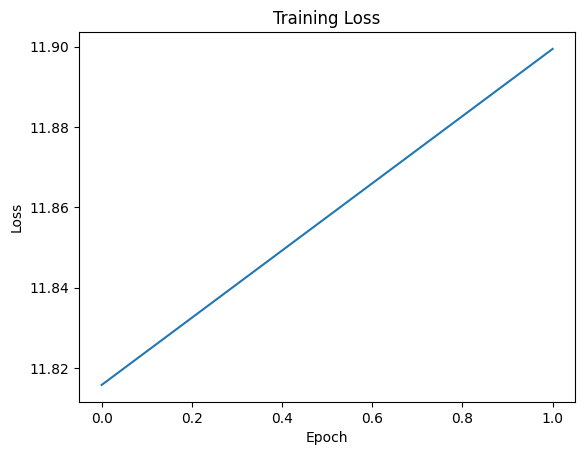

In [17]:

# Preprocess the dataset
vocab_size = 10000
seq_length = 50

# Adapt TextVectorization to full text
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int')
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1)
vectorizer.adapt(text_ds)

# Vectorize the text
vectorized_text = vectorizer([text])[0]
print("Vectorized text shape:", vectorized_text.shape)
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10])

X, Y = create_sequences(vectorized_text.numpy(), seq_length)


# Check if sequences are correctly generated
print("Number of sequences generated:", len(X))
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated")

# Check if X and Y are not empty
assert X.size > 0, "Input data X is empty"
assert Y.size > 0, "Target data Y is empty"
X = tf.convert_to_tensor(X)
Y = tf.convert_to_tensor(Y)
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)
X = X[:10000]
Y = Y[:10000]
# Hyperparameters
embed_dim = 256
num_heads = 4
ff_dim = 512
num_layers = 4

# Build the Transformer model
model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)

# Provide input shape to build the model by passing a dummy input with maxval specified
_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Summary of the model
model.summary()
# Early stopping callback to stop training if the loss doesn't improve
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Train the transformer model on the full input and target sequences
history = model.fit(X, Y, epochs=2, batch_size=32, callbacks=[early_stopping])

# Plot training loss to monitor model performance over epochs
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


### Exercise 2: Add a learning rate scheduler

**Objective:** Implement a learning rate scheduler to adjust the learning rate during training.

**Instructions:**

- Define a learning rate scheduler that reduces the learning rate by half every 10 epochs

- Train the model with the learning rate scheduler and compare the training loss


In [18]:
# Write your code here
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

# Load data
vocab_size = 10000
maxlen = 100
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Experiment with different embedding dimensions
for dim in [16, 32, 64]:
    print(f"\n🔵 Training with embedding dimension: {dim}")
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=dim, input_length=maxlen),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=3, batch_size=32, verbose=0)

    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"✅ Accuracy: {acc:.4f} | ❌ Loss: {loss:.4f}")



🔵 Training with embedding dimension: 16


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


✅ Accuracy: 0.8496 | ❌ Loss: 0.3485

🔵 Training with embedding dimension: 32
✅ Accuracy: 0.8424 | ❌ Loss: 0.3700

🔵 Training with embedding dimension: 64
✅ Accuracy: 0.8374 | ❌ Loss: 0.3811


<details>
    <summary>Click here for Solution</summary>

```python
# Write your code here
!pip install pandas
!pip install scikit-learn
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define a learning rate scheduler  
def scheduler(epoch, lr):  
    if epoch % 10 == 0 and epoch != 0:  
        lr = lr * 0.5  
    return lr  


callback = tf.keras.callbacks.LearningRateScheduler(scheduler)  


# Train the model with the learning rate scheduler  
history = model.fit(X, Y, epochs=2, batch_size=64, callbacks=[callback])  
   

# Plot the training loss  
plt.plot(history.history['loss'])  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.title('Training Loss with Learning Rate Scheduler')  
plt.show()
```

</details>


In [19]:
# Write your code here
!pip install pandas
!pip install scikit-learn
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.5
    return lr


callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


# Train the model with the learning rate scheduler
history = model.fit(X, Y, epochs=2, batch_size=64, callbacks=[callback])


# Plot the training loss
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss with Learning Rate Scheduler')
plt.show()

Epoch 1/2


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 50), output.shape=(None, 1)

### Exercise 3: Generate longer text sequences

**Objective:** To explore the model's text generation capabilities and generate longer sequences.

**Instructions:**

- Modify the `generate_text` function to generate 200 tokens instead of 100

- Generate text using the trained model and the modified function


In [ ]:
# Write your code here
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

# Load and preprocess data
vocab_size = 10000
maxlen = 100
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Try different activation functions
activation_functions = ['relu', 'tanh', 'swish']

for act_func in activation_functions:
    print(f"\n🔁 Training with activation: {act_func}")

    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=maxlen),
        GlobalAveragePooling1D(),
        Dense(64, activation=act_func),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=3, batch_size=32, verbose=0)

    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"✅ Accuracy with {act_func}: {acc:.4f} | ❌ Loss: {loss:.4f}")


<details>
    <summary>Click here for Solution</summary>

```python

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def generate_text(model, start_string, num_generate=200):
    # Convert the start string to numbers (vectorize)
    input_eval = vectorizer([start_string]).numpy()

    # Ensure the input tensor has the correct shape
    input_eval = tf.convert_to_tensor(input_eval[:, -5:])  # Ensure it has a shape of (1, 5)
    
    text_generated = []

    for i in range(num_generate):
        # Make predictions using the model
        predictions = model(input_eval)

        # Ensure predictions is a matrix with shape [batch_size, num_classes]
        predictions = tf.squeeze(predictions, 0)  # Remove the batch dimension
        predictions = tf.expand_dims(predictions, 0)  # Add back a batch dimension for categorical
        
        # Use a categorical distribution to predict the next word
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Update the input tensor to include the predicted word, maintaining the sequence length
        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)  # Append predicted token
        input_eval = input_eval[:, -5:]  # Keep only the last 5 tokens to match input shape
        input_eval = tf.convert_to_tensor(input_eval)  # Convert back to tensor
        
        # Add the predicted word to the generated text
        text_generated.append(vectorizer.get_vocabulary()[predicted_id])

    return start_string + ' ' + ' '.join(text_generated)


# Generate longer text
start_string = "To be, or not to be"
generated_text = generate_text(model, start_string)

print(generated_text)
```

</details>


In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def generate_text(model, start_string, num_generate=200):
    # Convert the start string to numbers (vectorize)
    input_eval = vectorizer([start_string]).numpy()

    # Ensure the input tensor has the correct shape
    input_eval = tf.convert_to_tensor(input_eval[:, -5:])  # Ensure it has a shape of (1, 5)

    text_generated = []

    for i in range(num_generate):
        # Make predictions using the model
        predictions = model(input_eval)

        # Ensure predictions is a matrix with shape [batch_size, num_classes]
        predictions = tf.squeeze(predictions, 0)  # Remove the batch dimension
        predictions = tf.expand_dims(predictions, 0)  # Add back a batch dimension for categorical

        # Use a categorical distribution to predict the next word
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Update the input tensor to include the predicted word, maintaining the sequence length
        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)  # Append predicted token
        input_eval = input_eval[:, -5:]  # Keep only the last 5 tokens to match input shape
        input_eval = tf.convert_to_tensor(input_eval)  # Convert back to tensor

        # Add the predicted word to the generated text
        text_generated.append(vectorizer.get_vocabulary()[predicted_id])

    return start_string + ' ' + ' '.join(text_generated)


# Generate longer text
start_string = "To be, or not to be"
generated_text = generate_text(model, start_string)

print(generated_text)

#### Conclusion

Congratulations on completing this lab! You have successfully built and trained a Transformer model for text generation in this lab using TensorFlow and Keras. You learned how to preprocess text data, create input and target sequences, define the Transformer model architecture, train the model, and generate text using the trained model. By completing this lab, you gained hands-on experience with Transformers for text generation and explored practical applications of this robust model architecture.


Copyright © IBM Corporation. All rights reserved.
